<a href="https://colab.research.google.com/github/ArshanBhanage/Clustering/blob/main/Image_Clustering_Using_ImageBind_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Clustering with ImageBind Embeddings

This Colab demonstrates image clustering using embeddings generated by the
ImageBind model on a subset of the CIFAR-10 dataset. It covers loading data,
generating embeddings, applying K-Means clustering, and visualizing the
results.


In [1]:
# Image clustering with ImageBind embeddings + CIFAR-10 images

!pip install -q datasets
!pip install -q git+https://github.com/facebookresearch/ImageBind.git

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 48.5 MB/s eta 0:00:00


In [ ]:
# Load CIFAR10 from torchvision (you could also use a HuggingFace image dataset)
transform = T.Compose([
    T.Resize((224, 224)),   # ImageBind expects 224x224
    T.ToTensor(),
])

cifar_train = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)

# Take a subset to keep it fast
N = 1000
subset_indices = list(range(N))
subset = torch.utils.data.Subset(cifar_train, subset_indices)

loader = DataLoader(subset, batch_size=32, shuffle=False)

print("Number of images:", len(subset))


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)


Using device: cuda


100%|██████████| 4.47G/4.47G [00:15<00:00, 306MB/s]


ImageBindModel(
  (modality_preprocessors): ModuleDict(
    (vision): RGBDTPreprocessor(
      (cls_token): tensor((1, 1, 1280), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Sequential(
          (0): PadIm2Video()
          (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
      )
      (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
        (pos_embed): tensor((1, 257, 1280), requires_grad=True)
        
      )
    )
    (text): TextPreprocessor(
      (pos_embed): tensor((1, 77, 1024), requires_grad=True)
      (mask): tensor((77, 77), requires_grad=False)
      
      (token_embedding): Embedding(49408, 1024)
    )
    (audio): AudioPreprocessor(
      (cls_token): tensor((1, 1, 768), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10), bias=False)
        (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=

In [4]:
all_embeddings = []
all_labels = []
all_images = []

# CIFAR10 labels (integers 0–9); we’ll keep them for reference
for imgs, labels in loader:
    imgs = imgs.to(device)

    with torch.no_grad():
        embeddings = model({
            ModalityType.VISION: imgs
        })[ModalityType.VISION]  # shape: (batch_size, d)

    all_embeddings.append(embeddings.cpu())
    all_labels.append(labels)
    all_images.append(imgs.cpu())

# Concatenate everything
all_embeddings = torch.cat(all_embeddings, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()
all_images = torch.cat(all_images, dim=0)

print("Embeddings shape:", all_embeddings.shape)
print("Labels shape:", all_labels.shape)
print("Images shape:", all_images.shape)


Embeddings shape: (1000, 1024)
Labels shape: (1000,)
Images shape: torch.Size([1000, 3, 224, 224])


In [5]:
k = 10

kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(all_embeddings)

print("Unique clusters:", np.unique(cluster_labels))


Unique clusters: [0 1 2 3 4 5 6 7 8 9]


In [6]:
sil = silhouette_score(all_embeddings, cluster_labels)
print("Silhouette score (ImageBind embedding space):", sil)


Silhouette score (ImageBind embedding space): 0.09098239


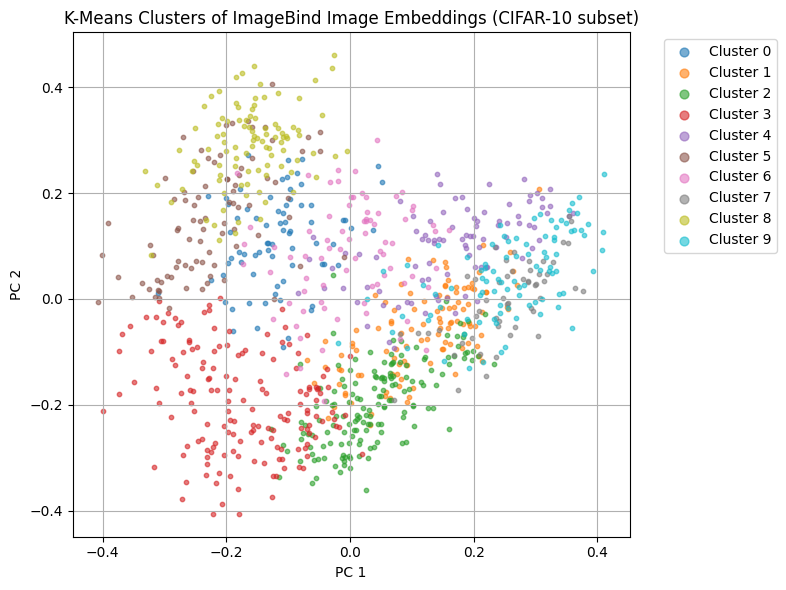

In [7]:
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(all_embeddings)

plt.figure(figsize=(8, 6))
for c in range(k):
    mask = cluster_labels == c
    plt.scatter(
        emb_2d[mask, 0],
        emb_2d[mask, 1],
        alpha=0.6,
        s=10,
        label=f"Cluster {c}"
    )

plt.title("K-Means Clusters of ImageBind Image Embeddings (CIFAR-10 subset)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


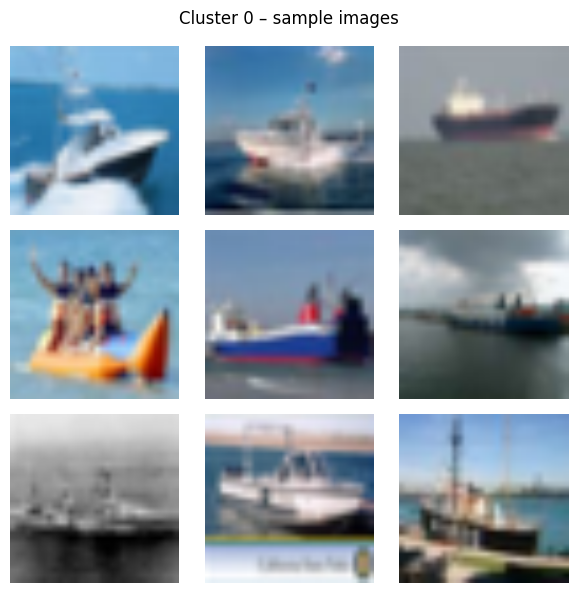

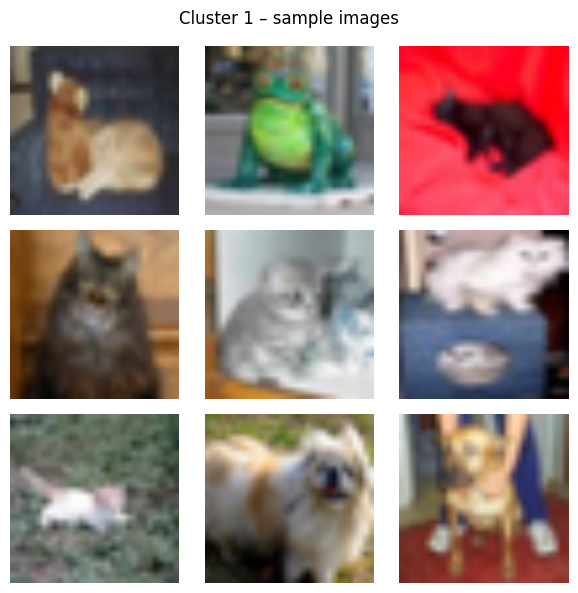

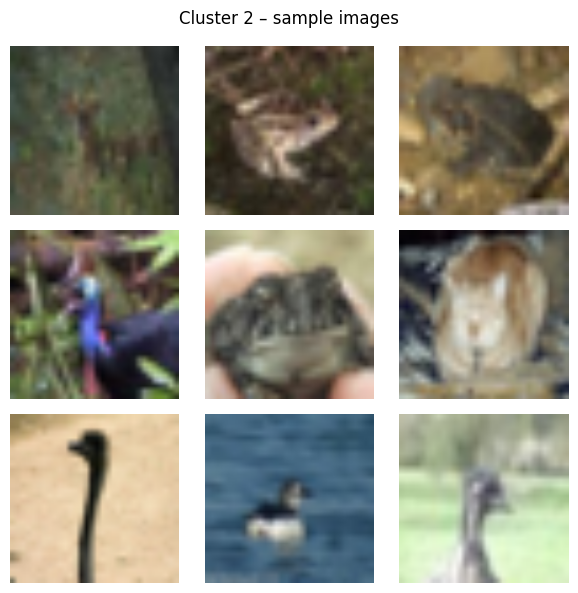

In [8]:
# Helper to show a grid of images from one cluster
def show_cluster_examples(cluster_id, num_images=9):
    idxs = np.where(cluster_labels == cluster_id)[0][:num_images]
    imgs = all_images[idxs]

    n = len(imgs)
    cols = 3
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(cols * 2, rows * 2))
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        # img: (C, H, W)
        plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        plt.axis("off")
    plt.suptitle(f"Cluster {cluster_id} – sample images")
    plt.tight_layout()
    plt.show()

# Display a few clusters
for c in range(3):  # show first 3 clusters for brevity
    show_cluster_examples(c, num_images=9)


In [9]:
from collections import Counter

print("Cluster → true label distribution (first few clusters):")
for c in range(k):
    idxs = np.where(cluster_labels == c)[0]
    cluster_true_labels = all_labels[idxs]
    counts = Counter(cluster_true_labels)
    if len(idxs) == 0:
        continue
    print(f"\nCluster {c}: {len(idxs)} images")
    print(counts)


Cluster → true label distribution (first few clusters):

Cluster 0: 73 images
Counter({np.int64(8): 71, np.int64(0): 2})

Cluster 1: 111 images
Counter({np.int64(3): 52, np.int64(5): 50, np.int64(6): 6, np.int64(2): 2, np.int64(7): 1})

Cluster 2: 158 images
Counter({np.int64(6): 86, np.int64(2): 25, np.int64(4): 14, np.int64(3): 10, np.int64(5): 10, np.int64(0): 6, np.int64(7): 5, np.int64(1): 1, np.int64(8): 1})

Cluster 3: 160 images
Counter({np.int64(3): 29, np.int64(8): 24, np.int64(5): 22, np.int64(9): 21, np.int64(0): 19, np.int64(2): 12, np.int64(6): 11, np.int64(1): 10, np.int64(7): 6, np.int64(4): 6})

Cluster 4: 91 images
Counter({np.int64(7): 88, np.int64(5): 2, np.int64(2): 1})

Cluster 5: 86 images
Counter({np.int64(9): 81, np.int64(1): 4, np.int64(0): 1})

Cluster 6: 77 images
Counter({np.int64(0): 74, np.int64(8): 3})

Cluster 7: 53 images
Counter({np.int64(2): 50, np.int64(6): 3})

Cluster 8: 98 images
Counter({np.int64(1): 97, np.int64(9): 1})

Cluster 9: 93 images
Co

In [10]:
cifar_classes = cifar_train.classes
print("CIFAR-10 classes:", cifar_classes)


CIFAR-10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Image Clustering with ImageBind Embeddings (CIFAR-10)

- **Dataset:** CIFAR-10 (subset of 1000 images).
- **Embeddings:** ImageBind vision encoder (`imagebind_huge`), which produces high-dimensional feature vectors for each image.
- **Pipeline:**
  1. Load a subset of CIFAR-10 images.
  2. Resize to 224×224 and send through ImageBind to obtain vision embeddings.
  3. Apply **K-Means** clustering to embeddings (k=10).
  4. Evaluate with **Silhouette score** in embedding space.
  5. Visualize clusters in 2D using PCA.
  6. Show sample images from each cluster and inspect how they group visually similar content.
- **Observation:** Images with similar semantic content (e.g., animals, vehicles) tend to fall into similar regions of the ImageBind embedding space, allowing simple clustering algorithms to separate them into meaningful groups.
